# Columbus Neighborhoods and Houses Assessment

## 1. Introduction/Business Problem

<font size="3">

__Business Problem__: Assess neighborhoods of selected houses in Columbus Ohio by looking at nearby venues, schools and crimes, and use the assessment to help clients to make decision of purchasing a house.

__Background__: The audiences whom this project aims at are real estate buyers and sellers. When we move in a house or apartment, we live not only in a building, but also in a neighborhood. We not only care about conditions and price of a house, but also safety, convenience, and good schools for kids. We need to evaluate the neighborhood of selected houses based on nearby venues, schools and crimes. Based on clients' preference, I design a ranking system and evaluate each neighborhood. I return a report to help clients to have a better assessment of the houses' environment and narrow down options.
<font>

## 2. Data Acquisition and Cleaning

### Data description:

<font size="3">

__Houses Information__: chose 10 houses from Realtor.com with the following filters: Location: Columbus OH, Price: from \\$180,000 to \\$220,000, Bedroom 3+, Bathroom 2+, Property Type: Single Family. The data is stored in RealEstateInfo.csv.

__Nearby Venues__: explore nearby venues within a mile of each house by __Foursquare API__. We obtain counts of different categories of venues by wrangling the raw data.

__Nearby Schools Information__: obtain evaluation of public schools (including district and charter) within 5 miles from each house from greatschools.org. GreatSchools’ Summary Rating is used to evaluate each school. The Top 1 school's score, Top 3 schools' average scores and the total number for elementary, middle and high schools respectively are listed in SchoolInfo.csv.

__Crimes Information__: obtain CrimeRisk™ Score and Probability of a Crime Claim from https://locationinc.com/claim-probability-tools/residential-crime-claim/ and store the data in CrimesInfo.csv.
    
I collect the following information to make the assessment be personalized for the clients.
    
__Clients' Preference Weight__: clients are asked to fill out a Preference Weight Form for the above information collected. Clients are asked to put weight (from 0 to 10) on how important the specific category of information for them.
<font>

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [26]:
#this jupyter note book use python version 3.7.6
from platform import python_version

print(python_version())

3.7.6


In [2]:
#foursquare account
CLIENT_ID = "4UFZAFUMNFADWCHWO2WWR1NJFL2Q1044QF2BEDOQXFJGW4DR"
CLIENT_SECRET =  # your Foursquare Secret
access_token = 
VERSION = '20200624' # Foursquare API version

In [3]:
#get json file of venues for the given postal code with the given location dataframe df_loc
def VenuesJson(latitude, longitude):
    #parameters
    LIMIT = 500
    radius = 1600
     # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                latitude, 
                longitude, 
                radius, 
                LIMIT)
    return requests.get(url).json()

#get category names from json file
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#get categories from venues in json format
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#get category counts from json data, return a series with category type and percentage
def get_category_counts(venues):
    nearby_venues = pd.json_normalize(venues) # flatten JSON
    s_temp = nearby_venues.apply(get_category_type, axis=1)
    s_temp2 = s_temp.map(convert)
    s_temp2 = s_temp2.replace(np.nan, 'OTHER')
    return  s_temp2.value_counts()

In [4]:
#wrangling housing date and add coordinates
df_house = pd.read_csv('RealEstateInfo.csv', thousands=',', encoding= 'unicode_escape')

#remove '\xa0'
for i in range(df_house.shape[0]):
    df_house.loc[i, 'ADDRESS'] = df_house.loc[i, 'ADDRESS'].replace('\xa0', ' ')
    
#add coordinates
geolocator = Nominatim(user_agent="cbus_explorer")
for i in range(df_house.shape[0]):
    address = df_house.loc[i, 'ADDRESS']
    location = geolocator.geocode(address)
    df_house.loc[i, 'LATITUDE'] = location.latitude
    df_house.loc[i, 'LONGITUDE'] = location.longitude    

#save the data into a csv file name RealEstateInfo(processed).csv
df_house.to_csv('RealEstateInfo(processed).csv', index = False)

In [5]:
df_house = pd.read_csv('RealEstateInfo(processed).csv')
df_house

,ADDRESS,BED,BATH,INNER_DIM,OUTER_DIM,PRICE,LATITUDE,LONGITUDE
0,"6039 Rover Ln, Columbus, OH 43232",3,2.5,1682,6098.0,185000,39.918816,-82.836154
1,"4416 Wingfield St, Columbus, OH 43231",3,2.0,1400,7405.0,180000,40.063049,-82.928520
2,"1292 Eagle View Dr, Columbus, OH 43228",3,2.0,1209,7405.0,210000,39.926817,-83.109923
3,"3785 Sunbury Rd, Columbus, OH 43219",3,2.0,1237,35719.2,214500,40.036869,-82.931113
4,"4270 Umiak Dr, Columbus, OH 43207",3,2.5,1936,7405.0,199999,39.879087,-82.966949
5,"3322 Pine Valley Rd, Columbus, OH 43219",3,3.5,1742,7405.0,184900,40.012570,-82.920537
6,"5029 Kilbourne Run Pl, Columbus, OH 43229",3,2.5,1498,10890.0,199900,40.072652,-82.953729
7,"936 Cypress Ridge Pl, Columbus, OH 43228",3,2.5,1476,24393.6,209900,39.931910,-83.129554
8,"2651 Winningwillow Dr, Columbus, OH 43207",3,2.5,1521,6970.0,195000,39.892353,-82.927716
9,"1392 Bryson Rd, Columbus, OH 43224",4,3.0,2066,8712.0,200000,40.053396,-82.980858


In [6]:
#visualize all housing location by using folium
import folium
print(folium.__version__)

#coordinates of Columbus
address = 'Columbus, Ohio, USA'

location = geolocator.geocode(address)
c_lat = location.latitude
c_long = location.longitude

# create map and display it
columbus_map = folium.Map(location=[c_lat, c_long], zoom_start=10)

# loop through the 100 crimes and add each to the map
for lat, lng, label in zip(df_house.LATITUDE, df_house.LONGITUDE, df_house.ADDRESS):
    folium.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        par_html = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(columbus_map)

columbus_map

0.11.0


__Nearby Venues__

In [7]:
#a list of dictionaries containing address and venues
features = []

for i in range(df_house.shape[0]):
    #coordinates
    latitude = df_house.LATITUDE[i]
    longitude = df_house.LONGITUDE[i]
    results = VenuesJson(latitude, longitude)
    try:
        venues = results['response']['groups'][0]['items']
    except:
        print(i)
    features.append({'address':df_house.ADDRESS[i], 'venues':venues})

In [8]:
import json

#save the venues data in a json file
json_dict = {'features': features}
with open('NearbyVenues.json', 'w') as json_file:
    json.dump(json_dict, json_file)

In [9]:
#read json file of venues data
import json

with open('NearbyVenues.json') as f:
    venues_json = json.load(f)

In [10]:
import ast

#dictionary of converting categories to 'parent' categories to reduce the number of categories
f = open('catogeries_convert_list.txt', 'r')
convert = f.read()
convert = ast. literal_eval(convert)
f.close()

In [11]:
#df_cat is a dataframe consists of categories and their counts
df_cat = pd.DataFrame(columns = ['categories'])

#process data from venues_json
for i in range(len(venues_json['features'])):
    venues = venues_json['features'][i]['venues']
    df_temp = pd.DataFrame(get_category_counts(venues), columns = [i]).reset_index()
    df_temp.rename(columns = {'index':'categories'}, inplace = True)
    #update df_cat by outer join with df_temp
    df_cat = df_cat.merge(df_temp, how = 'outer', on = 'categories')
    
df_cat.replace(np.nan, 0, inplace = True)
df_cat = df_cat.set_index('categories')
df_cat.index.name = None
df_cat = df_cat.T

df_cat = df_house[['ADDRESS', 'LATITUDE', 'LONGITUDE']].merge(df_cat, left_index = True, right_index = True)
df_cat.to_csv('NearbyVenuesByCategories.csv', index = False)
df_cat

,ADDRESS,LATITUDE,LONGITUDE,FOOD,OTHER,SHOPPING,RECREATION,GROCERY/MARKET,GAS_STATION,CONVENIENCE/PHARMACY,AUTO,HOME_SUPPLY,BAR,BANK/ATM,PET,BEAUTY
0,"6039 Rover Ln, Columbus, OH 43232",39.918816,-82.836154,16.0,11.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,0.0,0.0,0.0
1,"4416 Wingfield St, Columbus, OH 43231",40.063049,-82.928520,14.0,15.0,22.0,5.0,0.0,1.0,2.0,1.0,5.0,0.0,1.0,1.0,0.0
2,"1292 Eagle View Dr, Columbus, OH 43228",39.926817,-83.109923,30.0,12.0,1.0,1.0,1.0,4.0,1.0,0.0,2.0,0.0,2.0,0.0,2.0
3,"3785 Sunbury Rd, Columbus, OH 43219",40.036869,-82.931113,0.0,4.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
4,"4270 Umiak Dr, Columbus, OH 43207",39.879087,-82.966949,2.0,4.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
5,"3322 Pine Valley Rd, Columbus, OH 43219",40.012570,-82.920537,7.0,6.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,"5029 Kilbourne Run Pl, Columbus, OH 43229",40.072652,-82.953729,21.0,13.0,3.0,2.0,3.0,3.0,2.0,1.0,1.0,2.0,4.0,0.0,0.0
7,"936 Cypress Ridge Pl, Columbus, OH 43228",39.931910,-83.129554,27.0,14.0,1.0,1.0,1.0,4.0,3.0,0.0,1.0,2.0,0.0,0.0,1.0
8,"2651 Winningwillow Dr, Columbus, OH 43207",39.892353,-82.927716,1.0,6.0,0.0,9.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
9,"1392 Bryson Rd, Columbus, OH 43224",40.053396,-82.980858,21.0,11.0,1.0,1.0,3.0,3.0,3.0,1.0,1.0,0.0,4.0,1.0,0.0


__Nearby School Information__

In [12]:
df_school = pd.read_csv('SchoolInfo.csv')
df_school

,ADDRESS,LATITUDE,LONGITUDE,PUB_E_TOP1_SCORE,PUB_E_TOP3_AVE_SCORE,PUB_M_TOP1_SCORE,PUB_M_TOP3_AVE_SCORE,PUB_H_TOP1_SCORE,PUB_H_TOP3_AVE_SCORE,PUB_E_NUM,PUB_M_NUM,PUB_H_NUM
0,"6039 Rover Ln, Columbus, OH 43232",39.918816,-82.836154,8,7.00,7,6.67,7,6.00,38,22,17
1,"4416 Wingfield St, Columbus, OH 43231",40.063049,-82.928520,9,8.00,8,7.33,8,6.33,57,22,19
2,"1292 Eagle View Dr, Columbus, OH 43228",39.926817,-83.109923,9,7.33,9,7.67,9,6.33,36,19,12
3,"3785 Sunbury Rd, Columbus, OH 43219",40.036869,-82.931113,8,8.00,8,7.67,8,6.00,59,25,22
4,"4270 Umiak Dr, Columbus, OH 43207",39.879087,-82.966949,9,8.00,5,5.00,6,5.00,21,13,11
5,"3322 Pine Valley Rd, Columbus, OH 43219",40.012570,-82.920537,8,7.67,8,7.67,8,7.00,56,29,24
6,"5029 Kilbourne Run Pl, Columbus, OH 43229",40.072652,-82.953729,9,8.33,8,7.33,8,6.67,58,24,19
7,"936 Cypress Ridge Pl, Columbus, OH 43228",39.931910,-83.129554,9,7.33,9,7.67,9,5.33,34,18,10
8,"2651 Winningwillow Dr, Columbus, OH 43207",39.892353,-82.927716,9,7.00,7,6.00,7,6.67,41,23,21
9,"1392 Bryson Rd, Columbus, OH 43224",40.053396,-82.980858,9,8.33,7,7.00,9,8.00,59,28,26


__Crimes Information__

In [13]:
df_crime = pd.read_csv('CrimesInfo.csv')
df_crime

,ADDRESS,LATITUDE,LONGITUDE,CRIME_RISK_SCORE,PROBABILITY_CLAIM
0,"6039 Rover Ln, Columbus, OH 43232",39.918816,-82.836154,216,0.066667
1,"4416 Wingfield St, Columbus, OH 43231",40.063049,-82.928520,201,0.058824
2,"1292 Eagle View Dr, Columbus, OH 43228",39.926817,-83.109923,300,0.076923
3,"3785 Sunbury Rd, Columbus, OH 43219",40.036869,-82.931113,217,0.066667
4,"4270 Umiak Dr, Columbus, OH 43207",39.879087,-82.966949,160,0.050000
5,"3322 Pine Valley Rd, Columbus, OH 43219",40.012570,-82.920537,228,0.066667
6,"5029 Kilbourne Run Pl, Columbus, OH 43229",40.072652,-82.953729,168,0.052632
7,"936 Cypress Ridge Pl, Columbus, OH 43228",39.931910,-83.129554,216,0.066667
8,"2651 Winningwillow Dr, Columbus, OH 43207",39.892353,-82.927716,221,0.066667
9,"1392 Bryson Rd, Columbus, OH 43224",40.053396,-82.980858,193,0.058824


__Clients' Preference Weight__

The following Preference Weight Form is given as an example.

In [14]:
#client's preference: weight of each factor (from 0 to 10)
#columns name
columns_cat = df_cat.columns[3:]
columns_school = df_school.columns[3:]
#preference weigth form
wt_cat = pd.DataFrame([[8, 2, 4, 10, 6, 6, 10, 4, 6, 10, 10, 6, 6]], columns = columns_cat)
wt_school = pd.DataFrame([[10, 8, 10, 8, 10, 8, 4, 4, 4]], columns = columns_school)

In [38]:
print(', '.join(columns_cat).title())

Food, Other, Shopping, Recreation, Grocery/Market, Gas_Station, Convenience/Pharmacy, Auto, Home_Supply, Bar, Bank/Atm, Pet, Beauty


In [15]:
#weights for nearby venues
wt_cat

,FOOD,OTHER,SHOPPING,RECREATION,GROCERY/MARKET,GAS_STATION,CONVENIENCE/PHARMACY,AUTO,HOME_SUPPLY,BAR,BANK/ATM,PET,BEAUTY
0,8,2,4,10,6,6,10,4,6,10,10,6,6


In [16]:
#weights for nearby school information
wt_school

,PUB_E_TOP1_SCORE,PUB_E_TOP3_AVE_SCORE,PUB_M_TOP1_SCORE,PUB_M_TOP3_AVE_SCORE,PUB_H_TOP1_SCORE,PUB_H_TOP3_AVE_SCORE,PUB_E_NUM,PUB_M_NUM,PUB_H_NUM
0,10,8,10,8,10,8,4,4,4


## 3. Data Analysis

<font size = "3">
I normalize the data with Z-scale (i.e. mean = 0, std = 1). Then I use the following formula to obtain the score:

<center><b>score = data_normalized * 20 + 50</b></center>
    
From above formula, the average score is 50. The further above from 50, the better; the further below from 50, the worse.
The neighborhoods score is the average of the scores of nearby venues, nearby schools, and safety.
    
In the end, visualization of scores and price is provided.
<font>

In [17]:
from sklearn.preprocessing import StandardScaler

#venues
X_cat = np.array(df_cat.iloc[:, 3:])
#normalization
X_cat_norm = StandardScaler().fit_transform(X_cat)
#weighted score (weight * quantity)
score_cat = X_cat_norm.dot(np.array(wt_cat).T)
#rearange the score with average = 50
score_cat = StandardScaler().fit_transform(score_cat)
score_cat = score_cat*20 + 50
score_cat = np.ravel(score_cat).astype(int)  #ravel the array to 1D
print('venues score:', score_cat)

#safety: regularization of 1/CrimesRisk_Score
score_saf = 1/df_crime[['CRIME_RISK_SCORE']]
score_saf = StandardScaler().fit_transform(score_saf)
#rearange the score with average = 50
score_saf = score_saf*20 + 50
score_saf = np.ravel(score_saf).astype(int)   #ravel the array to 1D
print('safety score:', score_saf)

#school
X_sch = np.array(df_school.iloc[:, 3:])
#normalization
X_sch_norm = StandardScaler().fit_transform(X_sch)
#weighted score (weight * quantity)
score_sch = X_sch_norm.dot(np.array(wt_school).T)
#rearange the score with average = 50
score_sch = StandardScaler().fit_transform(score_sch)
score_sch = score_sch*20 + 50
score_sch = np.ravel(score_sch).astype(int)   #ravel the array to 1D
print('school score:', score_sch)

venues score: [64 63 56 27 19 18 73 64 43 67]
safety score: [44 53 11 43 85 38 78 44 41 58]
school score: [24 61 60 53  7 57 66 53 37 77]


In [18]:
#insert the above scores into dataframe
df_house.insert(5, "SCHOOL_SCORE", pd.DataFrame(score_sch))
df_house.insert(5, "SAFETY_SCORE", pd.DataFrame(score_saf))
df_house.insert(5, "VENUES_SCORE", pd.DataFrame(score_cat))
#NEIGH_SCORE is the average of above scores
df_house.insert(8, "NEIGH_SCORE", df_house.loc[:,'VENUES_SCORE':'SCHOOL_SCORE'].mean(axis = 1).astype(int))
#add PRICE/SQFT
df_house['PRICE/SQFT'] = (df_house['PRICE']/df_house['INNER_DIM']).astype(int)
#drop coordinates to remove unnecessary information
df_house.drop(['LATITUDE', 'LONGITUDE'], axis = 1, inplace = True)

In [19]:
df_house

,ADDRESS,BED,BATH,INNER_DIM,OUTER_DIM,VENUES_SCORE,SAFETY_SCORE,SCHOOL_SCORE,NEIGH_SCORE,PRICE,PRICE/SQFT
0,"6039 Rover Ln, Columbus, OH 43232",3,2.5,1682,6098.0,64,44,24,44,185000,109
1,"4416 Wingfield St, Columbus, OH 43231",3,2.0,1400,7405.0,63,53,61,59,180000,128
2,"1292 Eagle View Dr, Columbus, OH 43228",3,2.0,1209,7405.0,56,11,60,42,210000,173
3,"3785 Sunbury Rd, Columbus, OH 43219",3,2.0,1237,35719.2,27,43,53,41,214500,173
4,"4270 Umiak Dr, Columbus, OH 43207",3,2.5,1936,7405.0,19,85,7,37,199999,103
5,"3322 Pine Valley Rd, Columbus, OH 43219",3,3.5,1742,7405.0,18,38,57,37,184900,106
6,"5029 Kilbourne Run Pl, Columbus, OH 43229",3,2.5,1498,10890.0,73,78,66,72,199900,133
7,"936 Cypress Ridge Pl, Columbus, OH 43228",3,2.5,1476,24393.6,64,44,53,53,209900,142
8,"2651 Winningwillow Dr, Columbus, OH 43207",3,2.5,1521,6970.0,43,41,37,40,195000,128
9,"1392 Bryson Rd, Columbus, OH 43224",4,3.0,2066,8712.0,67,58,77,67,200000,96


In [25]:
#save the above table to results.csv
df_house.to_csv('results.csv', index = False)

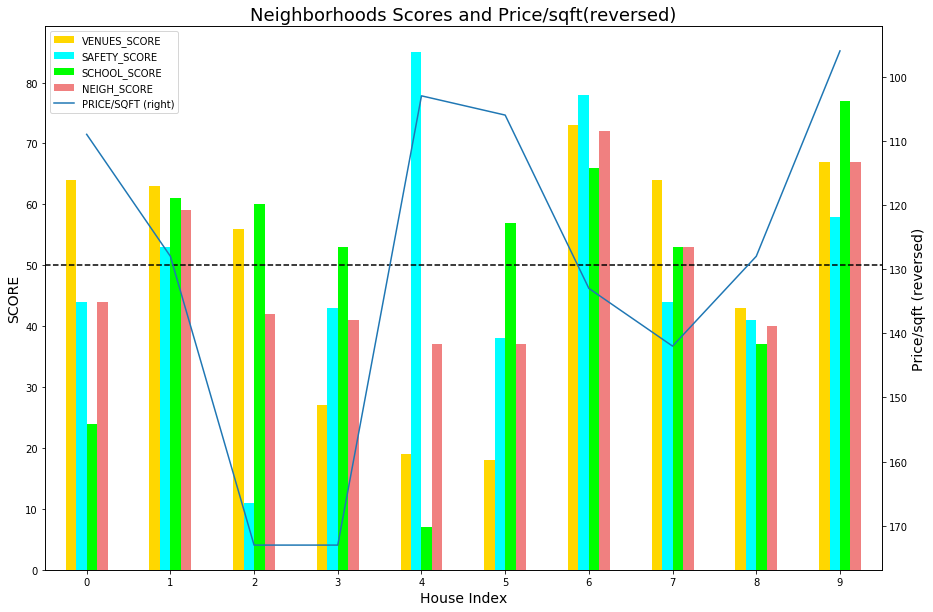

In [31]:
#visualization
#scores
color=['gold', 'aqua', 'lime', 'lightcoral']
df_house[['VENUES_SCORE','SAFETY_SCORE','SCHOOL_SCORE', 'NEIGH_SCORE']].plot(kind='bar', color = color, figsize = (15, 10))
plt.xlabel('House Index', fontsize = 14)
plt.hlines(y = 50, xmin = -0.5, xmax = 9.5, linestyles='dashed')
plt.ylabel('SCORE', fontsize = 14)
#price/sqft with reverse y-axis
df_house['PRICE/SQFT'].plot(secondary_y=True, legend = True)
plt.gca().invert_yaxis()  #reverse y-axis
plt.ylabel('Price/sqft (reversed)', fontsize = 14)
plt.title('Neighborhoods Scores and Price/sqft(reversed)', fontsize = 18)
plt.savefig('Neighborhoods Assessment and Home Values.png')

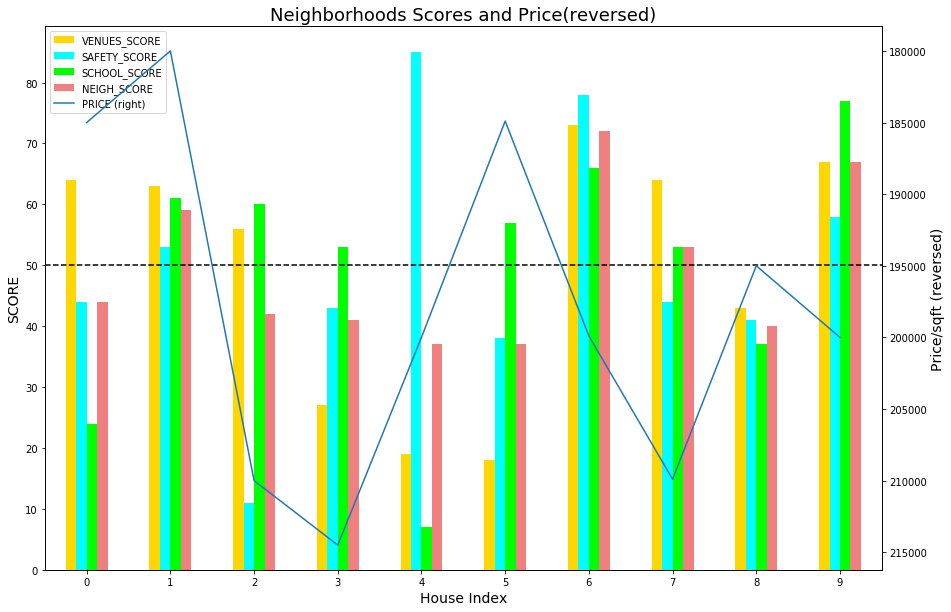

In [32]:
#visualization
#scores
color=['gold', 'aqua', 'lime', 'lightcoral']
df_house[['VENUES_SCORE','SAFETY_SCORE','SCHOOL_SCORE', 'NEIGH_SCORE']].plot(kind='bar', color = color, figsize = (15, 10))
plt.xlabel('House Index', fontsize = 14)
plt.hlines(y = 50, xmin = -0.5, xmax = 9.5, linestyles='dashed')
plt.ylabel('SCORE', fontsize = 14)
#price with reverse y-axis
df_house['PRICE'].plot(secondary_y=True, legend = True)
plt.gca().invert_yaxis()  #reverse y-axis
plt.ylabel('Price/sqft (reversed)', fontsize = 14)
plt.title('Neighborhoods Scores and Price(reversed)', fontsize = 18)
plt.savefig('Neighborhoods Assessment and Home Values2.png')